In [5]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

In [99]:
#physical constants from the problem statement
k1o = 2.9e5
k2o = 1970
k3o = 4.75
e1 = 58400
e2 = 68400
e3 = 22800
kcoO = 1360
deltaH = -48500
cp = 31.79
dv = 0.007**2*np.pi*0.1*1000*(1-0.36) #put into L

In [100]:
#Arrenhius relationship to recalculate the kinetic constants
def kt(ko, T, ei):
    return(ko*np.exp(ei/8.314*(1/473 - 1/T)))

In [101]:
#Rate laws from the problem statements
def r1(k1, yco, yo2, kco):
    return(k1*yco*yo2/(1+kco*yco)**2)

In [102]:
def r2(k2, yh2, yo2, yco, kco):
    return(k2*yh2*yo2/(1+kco*yco)**2)

In [103]:
def r3(k3, yco, yh2o, yh2, yo2, yco2):
    return(k3*(yco*yh2o - yh2*yo2/(yco2*yh2/yco/yh2o)))

In [104]:
#RK4 methods for each species
def dCO(h, k1, yco, yo2, kco, k3, yh2o, yh2, yco2):
    q1 = h*(-r1(k1, yco, yo2, kco) - r3(k3, yco, yh2o, yh2, yo2, yco2))
    q2 = h*(-r1(k1, yco + q1/2, yo2, kco) - r3(k3, yco + q1/2, yh2o, yh2, yo2, yco2))
    q3 = h*(-r1(k1, yco + q2/2, yo2, kco) - r3(k3, yco + q2/2, yh2o, yh2, yo2, yco2))
    q4 = h*(-r1(k1, yco + q3, yo2, kco) - r3(k3, yco + q3, yh2o, yh2, yo2, yco2))
    return(q1/6 + q2/3 + q3/3 + q4/6)

In [105]:
def dO2(h, k1, yco, yo2, kco, k2, yh2):
    q1 = h*(r1(k1, yco, yo2, kco) + r2(k2, yh2, yo2, yco, kco))
    q2 = h*(r1(k1, yco, yo2 + q1/2, kco) + r2(k2, yh2, yo2 + q1/2, yco, kco))
    q3 = h*(r1(k1, yco, yo2 + q2/2, kco) + r2(k2, yh2, yo2 + q2/2, yco, kco))
    q4 = h*(r1(k1, yco, yo2 + q3, kco) + r2(k2, yh2, yo2 + q3, yco, kco))
    return(q1/6 + q2/3 + q3/3 + q4/6)

In [106]:
def dH2O(h, k2, yh2, yo2, yco, kco, k3, yh2o, yco2):
    q1 = h*(r2(k2, yh2, yo2, yco, kco) - r3(k3, yco, yh2o, yh2, yo2, yco2))
    q2 = h*(r2(k2, yh2, yo2, yco, kco) - r3(k3, yco, yh2o + q1/2, yh2, yo2, yco2))
    q3 = h*(r2(k2, yh2, yo2, yco, kco) - r3(k3, yco, yh2o + q2/2, yh2, yo2, yco2))
    q4 = h*(r2(k2, yh2, yo2, yco, kco) - r3(k3, yco, yh2o + q3, yh2, yo2, yco2))
    return(q1/6 + q2/3 + q3/3 + q4/6)

In [149]:
#data setup and storage
totF = 0.13+0.001/0.21
yn2 = np.full((201,801), (0.13*0.269+0.003672)/totF)
yo2 = np.full((201,801), 0.001/totF)# our output is going to be a 2d array each row is the mole frac across the reactor at
yco = np.full((201,801), 0.13*0.015/totF) #given temperature and the rows are different temperatures 
yco2 = np.full((201,801), 0.13*0.148/totF)
yh2 = np.full((201,801), 0.13*0.317/totF)
yh2o = np.full((201,801), 0.13*0.248/totF)
Temp = np.full((201,801), 200.1)
Temp[:,0] = np.linspace(220,270,201).T #each row is the inital feed temp and then each time step
newTemp = np.empty(0)

In [150]:
h = 0.1 #arbitary for now, will ensure that no negative numbers show up. Might see if FLC condition can be applied here
for Tind in range(201):
    Tup = Temp[Tind, 0]
    k1 = kt(k1o, Tup, e1)
    k2 = kt(k2o, Tup, e2)
    k3 = kt(k3o, Tup, e3)
    kco = kt(kcoO, Tup, deltaH)
    
    for i in range(0,800):
        dco = dCO(h, k1, yco[Tind,i], yo2[Tind,i], kco, k3, yh2o[Tind,i], yh2[Tind,i], yco2[Tind,i])/totF
        yco[Tind,i+1] = yco[Tind,i] + dco
        yco2[Tind,i+1] = yco2[Tind,i] - dco #rCO2 = -rCO
        do2 = dO2(h, k1, yco[Tind,i], yo2[Tind,i], kco, k2, yh2[Tind,i])/totF
        yo2[Tind,i+1] = yo2[Tind,i] + do2
        dh2o = dH2O(h, k2, yh2[Tind,i], yo2[Tind,i], yco[Tind,i], kco, k3, yh2o[Tind,i], yco2[Tind,i])/totF
        yh2o[Tind,i+1] = yh2o[Tind,i] + dh2o
        yh2[Tind,i+1] = yh2[Tind,i] - dh2o #rH2 = -rH2O
        yn2[Tind,i+1] = 1-yh2[Tind,i+1]-yh2o[Tind,i+1]-yo2[Tind,i+1]-yco2[Tind,i+1]-yco[Tind,i+1]
        #find new temperature assume pressure of 1 atm and use previous temp
        n = 1*dv/(0.082057*Temp[Tind,i])
        q = dco*n*deltaH
        dt = q/n/cp
        Temp[Tind][i+1] = (Temp[Tind,i] + dt)
        #update all temperature dependent properties
        Tup = Temp[Tind, i+1]
        k1 = kt(k1o, Tup, e1)
        k2 = kt(k2o, Tup, e2)
        k3 = kt(k3o, Tup, e3)
        kco = kt(kcoO, Tup, deltaH)
        
#print(Temp[0,:])

Text(0.5, 1.0, 'Feed Temp vs. Outlet Concentration CO')

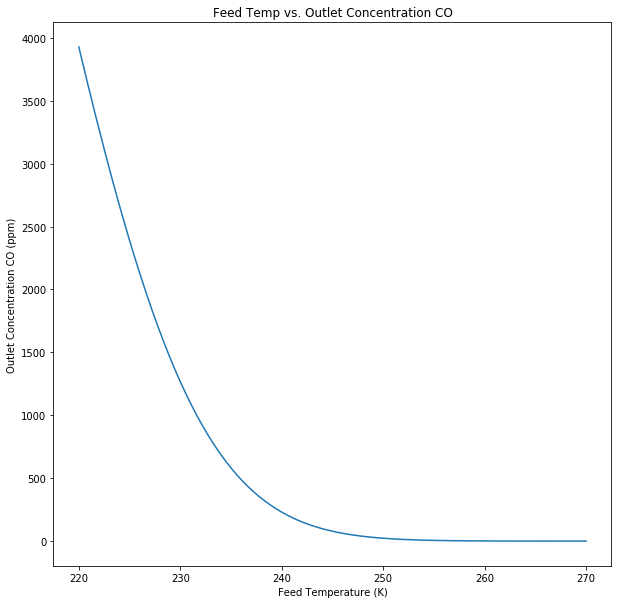

In [173]:
inletT = np.linspace(220,270,181)
plt.figure(figsize = (10,10))
plt.plot(inletT, yco[:181, -1]*1e6)
plt.xlabel('Feed Temperature (K)')
plt.ylabel('Outlet Concentration CO (ppm)')
plt.title('Feed Temp vs. Outlet Concentration CO')

We can see that at 250K we have hit our spec of 10ppm so the remainder of our graphs will be set from there

Text(0.5, 1.0, 'Temperature vs. Reactor volume (Feed temp = 250K)')

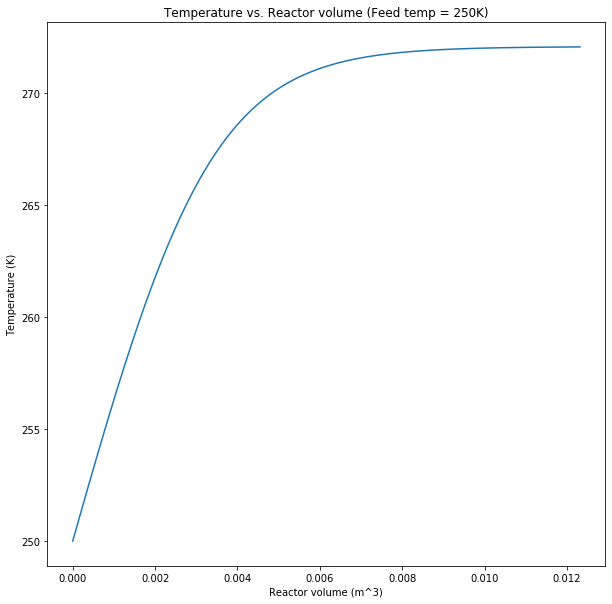

In [176]:
x = np.linspace(0,80,801)
v = x*0.007**2*np.pi
plt.figure(figsize=(10,10))
plt.plot(v,Temp[120,:])
plt.xlabel('Reactor volume (m^3)')
plt.ylabel('Temperature (K)')
plt.title('Temperature vs. Reactor volume (Feed temp = 250K)')

Text(0.5, 1.0, 'Mole Fraction vs. Reactor volume (Feed temp = 250K)')

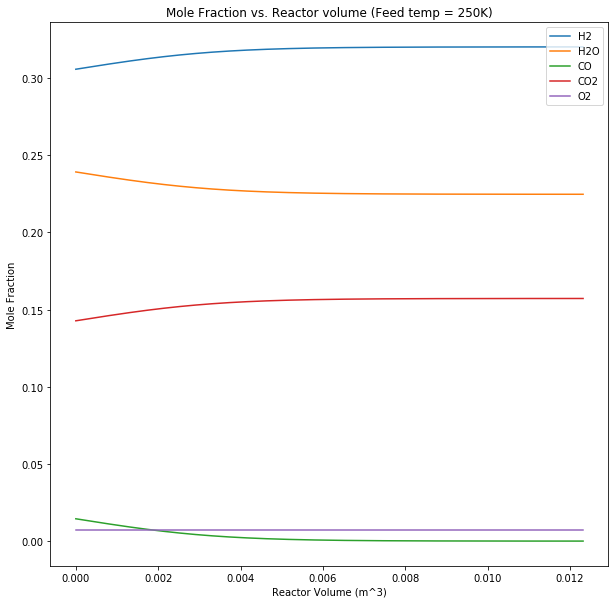

In [182]:
h2 = yh2[120,:]
h2o = yh2o[120,:]
co = yco[120,:]
co2 = yco2[120,:]
o2 = yo2[120,:]
plt.figure(figsize = (10,10))
plt.plot(v,h2)
plt.plot(v,h2o)
plt.plot(v,co)
plt.plot(v,co2)
plt.plot(v,o2)
plt.legend(['H2', 'H2O', 'CO', 'CO2', 'O2'])
plt.xlabel('Reactor Volume (m^3)')
plt.ylabel('Mole Fraction')
plt.title('Mole Fraction vs. Reactor volume (Feed temp = 250K)')

Text(0.5, 1.0, 'Outlet H2 vs. Feed Temperature')

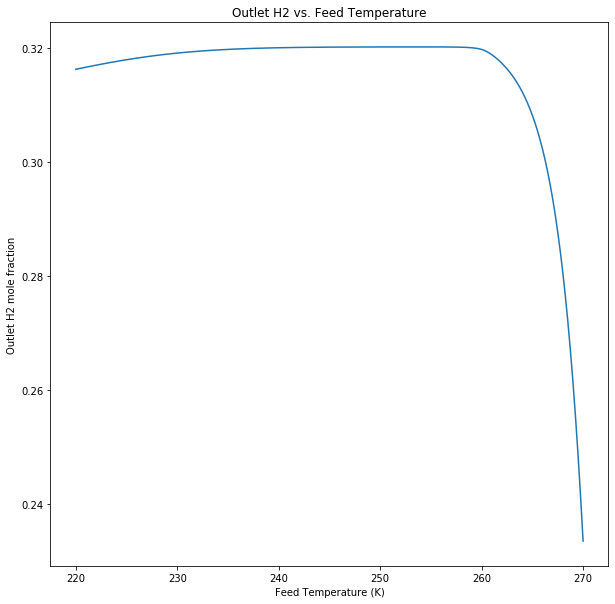

In [181]:
plt.figure(figsize = (10,10))
plt.plot(Temp[:,0], yh2[:,-1])
plt.xlabel('Feed Temperature (K)')
plt.ylabel('Outlet H2 mole fraction')
plt.title('Outlet H2 vs. Feed Temperature')

In [185]:
np.argmax(yh2[:,-1])
Temp[136,0]

254.0

In [186]:
np.max(yh2[:,-1])

0.3202729209397644